# 2CSSID Lab05. Regularization and Feature selection

<p style='text-align: right;font-style: italic;'>Designed by: Abdelkrime Aries</p>

In this lab, we will learn about:
- Regularization
- Feature selection 

**Team:**
- **Member 01**: ELBAR Nour El Imane
- **Member 02**: MESSAOUD Amal
- **Group**: SID1/SID2

In [1]:
import sys, timeit
import datetime
from typing          import Tuple, List, Type
from collections.abc import Callable

sys.version

'3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]'

In [2]:
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
import matplotlib
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('2.3.3', '2.3.3', '3.10.7')

In [3]:
import sklearn

from sklearn.metrics           import f1_score
from sklearn.linear_model      import LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector


sklearn.__version__

'1.7.2'

In [4]:
# This code is used to filter warnings concerning convergence
# In general, when the maximum number of iterations is not suffisant to converge
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [5]:
# Logistic regression code 
# Do not modify this code, or earth will eat itself

# Weighted sum
def zf(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return X @ theta

# Sigmoid function
def sg(Z: np.ndarray) -> np.ndarray:
    return  1 / (1 + np.exp(-Z))

# Probability estimation
def hf(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return sg(zf(X, theta))

# Loss function
def BCE(Y: np.ndarray, H: np.ndarray, e: float=1e-8) -> float: 
    return - np.mean(Y * np.log(H + e) + (1-Y) * np.log(1-H + e))  

# Gradients
def dBCE(X: np.ndarray, Y: np.ndarray, H: np.ndarray) -> np.ndarray:
    return  np.dot(X.T, H-Y)/X.shape[0]

# Parameters update
def update(Theta: np.ndarray, Gradient: np.ndarray, alpha: np.ndarray) -> np.ndarray: 
    return Theta - alpha * Gradient

# Normalization
def normalize(X: np.ndarray, mean: np.ndarray=None, std: np.ndarray=None) -> np.ndarray: 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std  = np.std(X, axis=0)
    X_norm = np.where(std==0, X, (X - mean)/std)
    return X_norm, mean, std


def prepare(X: np.ndarray, norm: np.ndarray=True, 
             const: np.ndarray=True, mean: np.ndarray=None, std: np.ndarray=None) -> np.ndarray: 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normalize(X_pre,mean=mean, std=std)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

def generate_zeros_1(nbr: int) -> np.ndarray:
    return np.zeros(nbr)

def generate_ones_1(nbr: int) -> np.ndarray:
    return np.ones(nbr)

print('DONE')

DONE


## I. Algorithms implementation

In this section, we will try to implement some regularization functions as well as a filtering one.
Regularization will be applied on logistic regression.

### I.1.  L2 penalty

L2 penalty + Linear regression = Ridge regression.

#### I.2.1. L2 cost function

**L2** cost function is calculated as: 

$$J_{L2}(\theta) = \frac{\lambda }{2M} \sum\limits_{j=1}^{N} \theta_j^2$$

- **M**: number of samples
- **N**: number of features


**Note** In some references, this regularization is not divided by $M$. In practice, it must be normalized over $M$. [This is an answer on stackexchange](https://stats.stackexchange.com/questions/287920/regularisation-why-multiply-by-1-2m) explaining why. A side information: for one sample, we call it 'loss function', for a batch it is called 'cost function'.

In [6]:
# TODO: L2 cost function
def J_L2(Theta: np.ndarray, M: int, Lambda: float=0.) -> float:
    return np.sum(Theta[1:] **2) * Lambda / (2 * M)

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0.0, 0.0005050000000000001)
#---------------------------------------------------------------------

# The first element is the bias, 
# thus it must not be included in the cost
Theta_t = np.array([1, 0.01, 0.1]) 


J_L2(Theta_t, 4), J_L2(Theta_t, 4, Lambda=.4)

(np.float64(0.0), np.float64(0.0005050000000000001))

#### 1.2.2. L2 gradient function

**L2** gradient function is given as:
 
$$\frac{\partial J_{L2}(\theta)}{\partial \theta_j} = \frac{\lambda }{M} \theta_j \text{ if } j > 0$$

$$\frac{\partial J_{L2}(\theta)}{\partial \theta_0} = 0$$

- **M**: number of samples
- **N**: number of features


In [7]:
# TODO: L2 gradient function
def dJ_L2(Theta: np.ndarray, M: int, Lambda: float=0.) -> np.ndarray:
    grad = np.zeros_like(Theta)
    grad[1:] = Theta[1:] * Lambda / M
    return grad


#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))
#---------------------------------------------------------------------

# The first element is the bias, 
# thus it must always have a gradient of 0
Theta_t = np.array([1, 0.01, 0.1])

dJ_L2(Theta_t, 4), dJ_L2(Theta_t, 4, Lambda=0.4)

(array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))

### I.2.  L1 penalty

L1 penalty + Linear regression = Lasso regression.

#### I.2.1. L1 cost function

**L1** cost function is calculated as: 

$$J_{L1}(\theta) = \frac{\lambda}{M} \sum\limits_{j=1}^{N} |\theta_j|$$

- **M**: number of samples
- **N**: number of features

In [8]:
# TODO: L1 cost function
def J_L1(Theta: np.ndarray, M: int, Lambda: float=0.) -> float:
    J_L1 = Lambda / M * np.sum(np.abs(Theta[1:]))
    return J_L1

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0.0, 0.011000000000000001)
#---------------------------------------------------------------------

# The first element is the bias, 
# thus it must not be included in the cost
Theta_t = np.array([1, 0.01, 0.1])

J_L1(Theta_t, 4), J_L1(Theta_t, 4, Lambda=.4)

(np.float64(0.0), np.float64(0.011000000000000001))

#### I.2.2. Soft-Thresholding

$L1$ derivative is:
$$\frac{\partial L1}{\partial \theta_j} = \frac{\partial \frac{\lambda }{M} \sum\limits_{j=1}^{N} |\theta_j|}{\partial \theta_j} = \frac{\lambda }{M} \frac{\theta_j}{|\theta_j|}$$

It is clear that the gradient is not defined when $\theta_j = 0$. 
Applying [Subderivative](https://en.wikipedia.org/wiki/Subderivative), we'll get: 
$$
\frac{\partial L1}{\partial \theta_j} = 
\begin{cases}
-\frac{\lambda}{M} & \text{if } \theta_j < 0 \\
0 & \text{si } \theta_j = 0 \\
\frac{\lambda}{M} & \text{if } \theta_j > 0 \\
\end{cases}
$$

Nous ne pouvons pas utiliser la descente du gradient pour résoudre ça. 
Nous allons utiliser un algorithme de descente du gradient approximative, qui s'appelle **Iterative soft-thresholding algorithm (ISTA)**. 
$$prox(\theta) = S_{\lambda}(\theta) = 
\begin{cases}
\theta_j + \lambda & \text{si } \theta_j < - \lambda \\
0 & \text{si } -\lambda \le \theta_j \le \lambda \\
\theta_j - \lambda & \text{si } \theta_j > \lambda \\
\end{cases}
$$

**Vous devez implémenter cette fonction**

Les thétas sont mises à jour comme suite : 
$$ \theta = S_{\lambda}(\theta - \frac{\partial J_0}{\partial \theta})$$
Où, $J_0$ est la fonction du coût sans régularisation

Source : [Ryan Tibshirani (2015), Lecture 08: Proximal Gradient Descent](https://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)

In [9]:
# TODO: Soft-thresholding = prox(theta)
def S(Theta: np.ndarray, Lambda: float) -> np.ndarray: 
    S = Theta.copy()
    mask = S[1:] < -Lambda
    S[1:][mask] = S[1:][mask] + Lambda
    
    mask = S[1:] > Lambda
    S[1:][mask] = S[1:][mask] - Lambda
    
    mask = (S[1:] >= -Lambda) & (S[1:] <= Lambda)
    S[1:][mask] = 0.0
    return S

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# array([ 0.5 , -0.15,  0.  ])
#---------------------------------------------------------------------

# The first element is the bias, 
# thus it must not be changed by soft-thresholding
Theta_t = np.array([0.5, -0.25, 0.05])

S(Theta_t, 0.1)

array([ 0.5 , -0.15,  0.  ])

### I.3. Regularized logistic regression

**>> Nothing to code here**

In [10]:
# これをいじると舌が青くなるよ
# This can be gradient descent or ISTA based on the approx function
def optimize(X: np.ndarray, Y: np.ndarray, Theta: np.ndarray, approx: Callable=None, it_max: int=100, alpha: float=0.1, Lambda: float=0.): 

    M = len(Y)
    
    if approx :
        def maj(Theta, J, dJ):
            J    += J_L1(Theta, M, Lambda=Lambda)
            Theta = update(Theta, dJ, alpha)
            Theta = S(Theta, Lambda/M) # Lamdba is normalized by th number of samples before applying S
            return J, Theta
    else:
        def maj(Theta, J, dJ):
            J    += J_L2(Theta, M, Lambda=Lambda)
            dJ   += dJ_L2(Theta, M, Lambda=Lambda)
            Theta = update(Theta, dJ, alpha)
            return J, Theta
            
    cost_history  = []
    Theta_history = []
    
    # we use a copy so that the input stays intact
    Theta  = Theta.copy()
    
    # here, we iterate till the last breath
    for it in range(it_max):
        H        = hf(X, Theta)
        J        = BCE(Y, H)
        dJ       = dBCE(X, Y, H)
        J, Theta = maj(Theta, J, dJ)
        cost_history.append(J)
        Theta_history.append(Theta.copy())
    
    return Theta_history, cost_history

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (array([ 0.94839532, -0.56840255,  1.2813832 ]),
#  array([ 0.46328109, -0.15750488,  0.        ]),
#  array([ 0.93431089, -0.53451115,  1.03711393]))
#
#---------------------------------------------------------------------

X_t = np.array([
    [1, 1, 0.2],
    [1, 2, 0.1],
    [1, 3, 0.4],
    [1, 4, 0.3]
])

Theta_t = np.array([1., 1., 1.])
Y_t     = np.array([1, 0, 1, 0])

# No regularization: Lambda = 0
Theta_P, J_P = optimize(X_t, Y_t, Theta_t)
# L1 optimization: approximation with lambda
Theta_1, J_1 = optimize(X_t, Y_t, Theta_t, approx=S, Lambda=0.1)
# L2 optimization: lambda without approximation
Theta_2, J_2 = optimize(X_t, Y_t, Theta_t, Lambda=0.1)

Theta_P[-1], Theta_1[-1], Theta_2[-1]

(array([ 0.94839532, -0.56840255,  1.2813832 ]),
 array([ 0.46328596, -0.15750653,  0.        ]),
 array([ 0.93431089, -0.53451115,  1.03711393]))

In [11]:
# Do not modify this
# if you do, you'll get a Vin Diesel head
class RegLogReg(object): # Regularized Logistic Regression
    
    # By default: no regularization :'(
    def __init__(self, it_max: int=100, 
                 alpha: float=.01, Lambda: float=1.0, norm: bool=True, const: bool=True, reg: str=None): 
        self.it_max = it_max
        self.alpha    = alpha
        self.norm     = norm
        self.const    = const
        self.approx   = None
        self.Lambda   = Lambda
        if reg == 'l1':
            self.approx = S
        elif reg != 'l2':
            self.Lambda = 0.
    
    def fit(self, X: np.ndarray, Y: np.ndarray): 
        # we have to store mean and std to normalize when predicting
        X_pre, self.mean, self.std = prepare(X, norm=self.norm, const=self.const)
        Theta = generate_ones_1(X_pre.shape[1])
        self.Thetas, self.couts = optimize(X_pre, Y, Theta, 
                                          approx=self.approx, 
                                          it_max=self.it_max, 
                                          alpha =self.alpha, 
                                          Lambda=self.Lambda)
        
    # Prediction
    # if cls=True, the result is a vector of  1 and 0
    # otherwise, it will be a veector of probabilities
    def predict(self, X: np.ndarray, cls: bool=True, thrshold: float=0.5, it: int=-1) -> np.ndarray:
        X_pre, self.mean, self.std = prepare(X, norm=self.norm, const=self.const, mean=self.mean, std=self.std)
        H = hf(X_pre, self.Thetas[it])
        if cls:
            return (H >= thrshold).astype(int)
        return H

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (array([0.86383643, 0.5273866 , 0.96123235]),
#  array([0.79153709, 0.        , 0.        ]),
#  array([0.8515839 , 0.38351525, 0.7672672 ]),
#  array([0, 0, 1, 1]))
#---------------------------------------------------------------------

X_t = np.array([
    [100, 20],
    [200, 10],
    [300, 40],
    [400, 30]
])

Y_t = np.array([1, 0, 1, 0])

# No regularization
reglog = RegLogReg()
reglog.fit(X_t, Y_t)
# L1 regularization
reglog1 = RegLogReg(reg='l1')
reglog1.fit(X_t, Y_t)
# L2 regularization
reglog2 = RegLogReg(reg='l2')
reglog2.fit(X_t, Y_t)

reglog.Thetas[-1], reglog1.Thetas[-1], reglog2.Thetas[-1], reglog.predict(X_t)

(array([0.86383643, 0.5273866 , 0.96123235]),
 array([0.79237231, 0.        , 0.        ]),
 array([0.8515839 , 0.38351525, 0.7672672 ]),
 array([0, 0, 1, 1]))

### I.4. Filtering (ANOVA: Analysis of Variance)

For each class, there is a different number of samples.
This is why we will implemeent ANOVA for a CRD (COMPLETELY RANDOM DESIGN). 
The algorithm is explained in [Richard Horsly (2012) COMPLETELY RANDOM DESIGN (CRD)](https://www.ndsu.edu/faculty/horsley/CRD.pdf). 
To validate, we will use the example in page 10.

#### I.4.1. One way F value for one feature

Given a feature ($A$), its values are divided into $N$ sets, where $N$ is the number of classes. 

$$CF = \frac{(\sum_{ij} A_{ij})^2}{\sum_j |A_j|} $$
Where $\sum_{ij} A_{ij}$ is the sum of all values of all classes, 
$\sum_j |A_j|$ is the number of samples

$$ TotalSS = \sum_{ij} A_{ij}^2 - CF$$
Where $\sum_{ij} A_{ij}^2$ is the sum est les somme of values' squares

$$ TreatmentSS = \sum_j \frac{(\sum_{i} A_{ij})^2}{|A_j|} - CF$$
Where $\sum_{i} A_{ij}$ is the sum of all valus of class $j$ and $|A_j|$ is the number of samples in class $j$

$$ ErrorSS = TotalSS - TreatmentSS $$


In [12]:
# TODO: One-way ANOVA for one feature
def f_oneway(A: np.ndarray) -> float: 
    # 'A' is a list of N lists where N is the number of classes
    # These lists do not have the same size
    nbrs = np.array([len(a) for a in A]) # Number of samples in each class
    sums = np.array([np.sum(a) for a in A]) # Sum of values of each class
    ssum = np.sum([np.sum(np.array(a)**2) for a in A]) # Sum of all squared values
    
    # Complete here
    #====================================
    CF          = np.sum(sums) ** 2 / np.sum(nbrs)
    TotalSS = ssum - CF
    TreatmentSS = np.sum((sums ** 2) / nbrs) - CF
    ErrorSS = TotalSS - TreatmentSS
    #====================================
    
    MSB = TreatmentSS / (len(A) - 1) 
    MSW =  ErrorSS/(nbrs.sum() - len(A))
    return MSB/MSW


#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# 6.418894830659841 (see page 11 step 6)
#---------------------------------------------------------------------

AA = [[2., 2.2, 1.8, 2.3, 1.7], [1.7, 1.9, 1.5], [2., 2.4, 2.7, 2.5, 2.4], [2.1, 2.2, 2.2, 1.9]]

f_oneway(AA)

np.float64(6.418894830659841)

#### I.4.2. One way F value for all feature

**>> Nothing to code here**

Here, we will calculate ANOVA F value for each feature.
Features with the highest F-value are the best.

In [13]:
# Do not modify,
# If you do, your laptop will enslave you
def anova_f(X: np.ndarray, Y: np.ndarray) -> np.ndarray: 
    
    C = np.unique(Y)
    F = []
    for j in range(X.shape[1]): 
        A = X[:, j]
        F.append(f_oneway([A[Y==c] for c in np.unique(Y)]))
    return np.array(F)


#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (array([  6.41889483,   0.40595497, 105.2745098 ]),
#  array([  6.41889483,   0.40595497, 105.2745098 ]))
#---------------------------------------------------------------------

X_t = np.array(
    [[2. , 1. , 1. ],
     [2.2, 2. , 1. ],
     [1.8, 3. , 1. ],
     [2.3, 4. , 1. ],
     [1.7, 5. , 2. ],
     [1.7, 1. , 2. ],
     [1.9, 2. , 2. ],
     [1.5, 3. , 2. ],
     [2. , 1. , 3. ],
     [2.4, 2. , 3. ],
     [2.7, 3. , 3. ],
     [2.5, 4. , 3. ],
     [2.4, 5. , 3. ],
     [2.1, 1. , 4. ],
     [2.2, 2. , 4. ],
     [2.2, 3. , 4. ],
     [1.9, 4. , 4. ]])

Y_t = np.array(['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D'])

# To validate, we will use scikit-learn's f_classif
# https://github.com/scikit-learn/scikit-learn/blob/95d4f0841d57e8b5f6b2a570312e9d832e69debc/sklearn/feature_selection/_univariate_selection.py#L42

f_sklearn, a = f_classif(X_t, Y_t)
f_notre      = anova_f  (X_t, Y_t)

# The first list is F-value of scikit-learn, the second is ours
f_sklearn, f_notre

(array([  6.41889483,   0.40595497, 105.2745098 ]),
 array([  6.41889483,   0.40595497, 105.2745098 ]))

## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it. 
We will use the dataset [Diabetics prediction using logistic regression](https://www.kaggle.com/kandij/diabetes-dataset). 

In [14]:
diabetes   = pd.read_csv('data/diabetes2.csv') 
X_diabetes = diabetes.iloc[:, :-1].values  
Y_diabetes = diabetes.iloc[:,  -1].values

# This configuration is intended to be as such
# We want to test the case where logistic regression is disadvantaged
NBR_TEST = 240 # 30%
# Supposee the first NBR_TEST samples are used for test, the rest for train
X_test  = X_diabetes[-NBR_TEST:, :]
Y_test  = Y_diabetes[-NBR_TEST:   ]

X_train = X_diabetes[:-NBR_TEST, :] 
Y_train = Y_diabetes[:-NBR_TEST   ]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### II.1. Regularization

We trained 3 models:
- **lreg_00**: Logistic regression without regularization
- **lreg_l1**: Logistic regression with L1 regularization
- **lreg_l2**: Logistic regression with L2 regularization

To test these models, we will use the two datasets (with F1-score history):
- **train**: to evaluate models' fitting
- **test** : to evaluate models' generalization

To capture F1-score and paramteres history, we created models with only one iteration.
Then, we iterate outside "fit" function and call it each time.
To ensure that the model continues updating and not randomize parameters values, we activated the option **warm_start**.
In this case, the history graph will not as smooth as it should be.

**Note**: All parameters are initialized by 1, so we will exclude the possibility of a model having a favorable start point (near to the optimum).


In [15]:
MAX_IT     = 500
CC         = 0.002

ITLST = list(range(MAX_IT))

# Initialize model's parameters to a predefined vector
def init_params(mdl: LogisticRegression, value:float=1., N=X_train.shape[1]):
    mdl.coef_      = np.array([[value] * N])
    mdl.intercept_ = np.array([value])

models = [
    ('00', LogisticRegression(penalty=None, solver='saga', max_iter=1, warm_start=True, random_state=0      )),
    ('L1', LogisticRegression(penalty='l1', solver='saga', max_iter=1, warm_start=True, random_state=0, C=CC)),
    ('L2', LogisticRegression(penalty='l2', solver='saga', max_iter=1, warm_start=True, random_state=0, C=CC))
]

history = {'Theta': {}, 'F1_train': {}, 'F1_test': {}}

for mdl_name, mdl in models:
    # Initialize all parameters to a shared start point
    init_params(mdl)
    history['Theta'   ][mdl_name] = []
    history['F1_test' ][mdl_name] = []
    history['F1_train'][mdl_name] = []


for it in ITLST:
    for mdl_name, mdl in models:
        mdl.fit(X_train, Y_train)
        coef = [mdl.intercept_[0]]
        coef.extend(mdl.coef_.flatten().tolist())
        history['Theta'][mdl_name].append(coef)
        history['F1_test'][mdl_name].append(f1_score(Y_test, mdl.predict(X_test)))
        history['F1_train'][mdl_name].append(f1_score(Y_train, mdl.predict(X_train)))

for mdl_name, mdl in models:
    history['Theta'][mdl_name] = np.array(history['Theta'][mdl_name])

# This is just to check the last time this was executed
# because the next cells depend on the results of this one
now = datetime.datetime.now()
print(now.strftime("%Y-%m-%d %H:%M:%S"))


2025-12-16 15:32:00


#### II.1.1.  Regularization and fitting/generalization

According to the train graph, we suppose a model has converged when it is in its highest F1-score peak.
For example, **Reg-L2** reached its highest F1-score around 150 iterations.
After that point, we want just to see what will happen if we keep training.

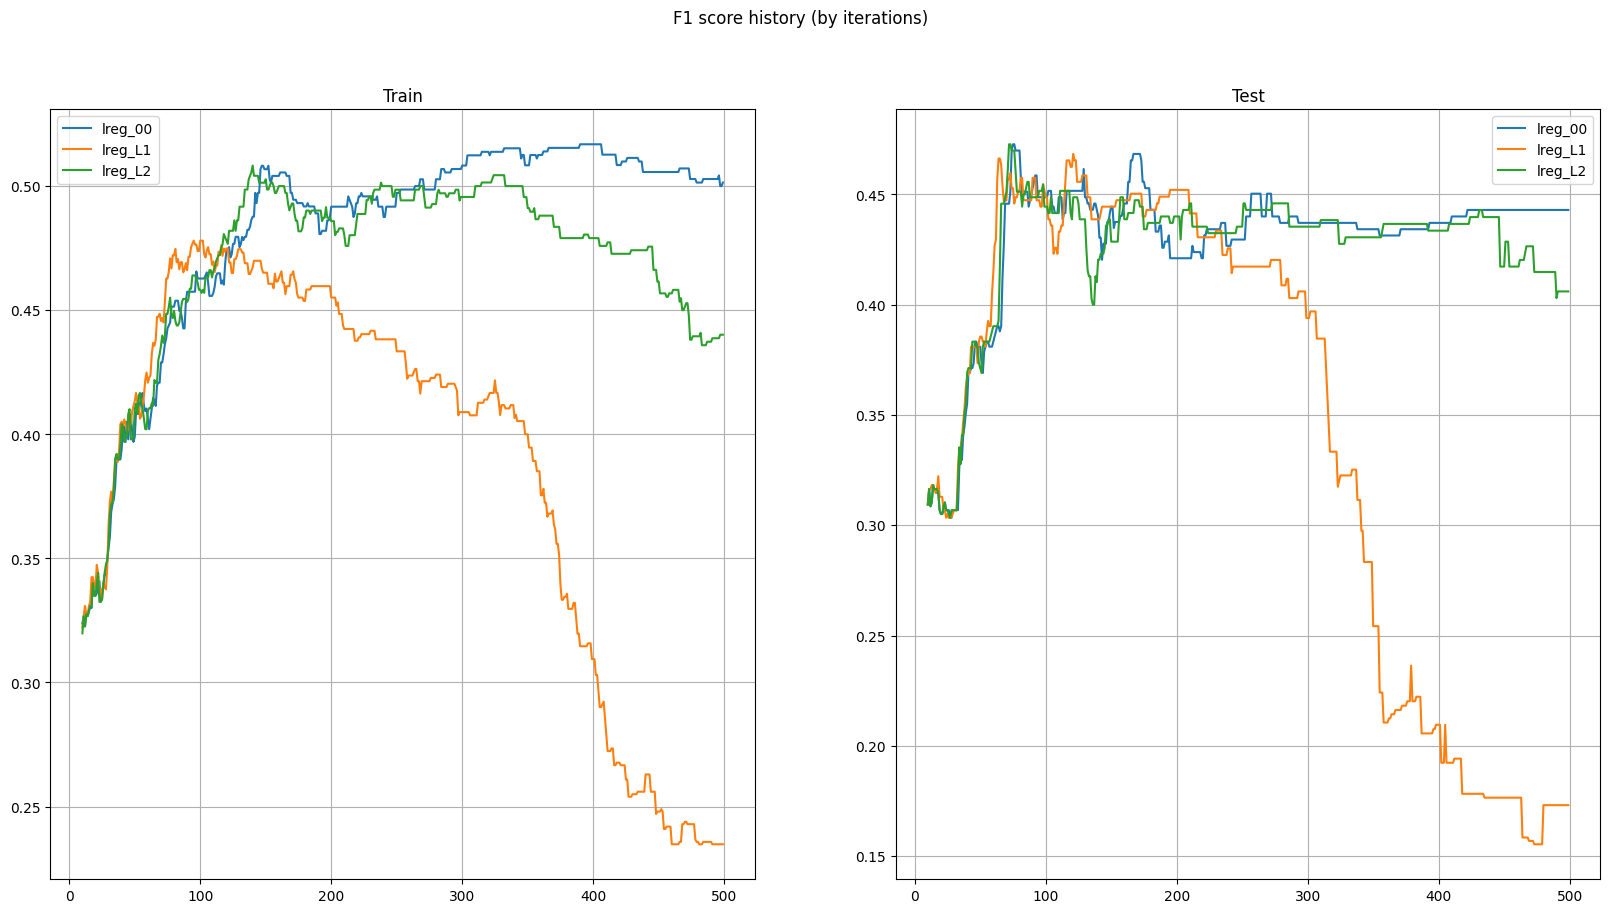

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('F1 score history (by iterations)')
fig.set_figwidth (20)
fig.set_figheight(10)


for mdl_name, mdl in models:
    ax1.plot(ITLST[10:], history['F1_train'][mdl_name][10:], label='lreg_' + mdl_name)
    ax2.plot(ITLST[10:], history['F1_test' ][mdl_name][10:], label='lreg_' + mdl_name)

ax1.legend()
ax2.legend()
ax1.set_title('Train')
ax2.set_title('Test')
ax1.grid()
ax2.grid()

plt.show()

**TODO: Analyze the results**

1. Analyze convergence (Train-graph): which model converges the fastest? with what price (what is the gain or loss)?
1. Explain why?
1. Based on that (nothing else), what is the benefit of regularization? 
1. Why regularized models lose performance with much more iterations? for train + test
1. Based on that (nothing else), what is the limit of regularization?  

**Answer**

1. The lreg_L1 model has the fastest convergence, reaching its peak F1-score ($\approx 0.475$) on around 100 iterations, which is earlier than lreg_L2 and lreg_00 (both $\approx 150$ iterations). The gain is reaching convergence at minimal iteration count. The loss is the severe degradation in performance when not stopping at the optimal reached point (below 0.25 when 500 iteration),unlike the other model's which, although converge later, but do somewhat hold that performance for a longer time.

   
1. Regularization, by adding a penalty to the objective function , constrains the optimization search space, enabling the solver to reach a local optimum more rapidly. L1 reg promotes sparsity by driving feature coefficients to 0 after a few iterations unlike L2 reg which reduces feature weights close to 0 without eliminating them completely. In addition, the search space for regularized models is constrained making them converge to local min, while regularized models explore all the search space to reach the global min performing evently better than L1 and L2.
   
1. The benefit of regularization here is faster convergence, clearly seen for L1 and slightly for L2 compared to the non-regularized model because the regularization term guides the parameter update process, making the weight space more constrained and easier to navigate for the optimization algorithm.
   
1. When increasing the number of iterations in regularized models, the penalty becomes severe because it begins to shrink important parameters too much. This causes more parameters to have their weights set to exactly 0 for L1 reg and close to 0 for L2 reg, ultimately simplifying the model excessively. The model loses its ability to learn relevant patterns within the data, leading to underfitting.
   
1. The limit of regularization is over-regularization. With too many iterations, the model underfits and loses its dependence on relevant attributes, resulting in poor performance.

#### II.1.2. Regularization and parameters

Here, we will plot parameters history.

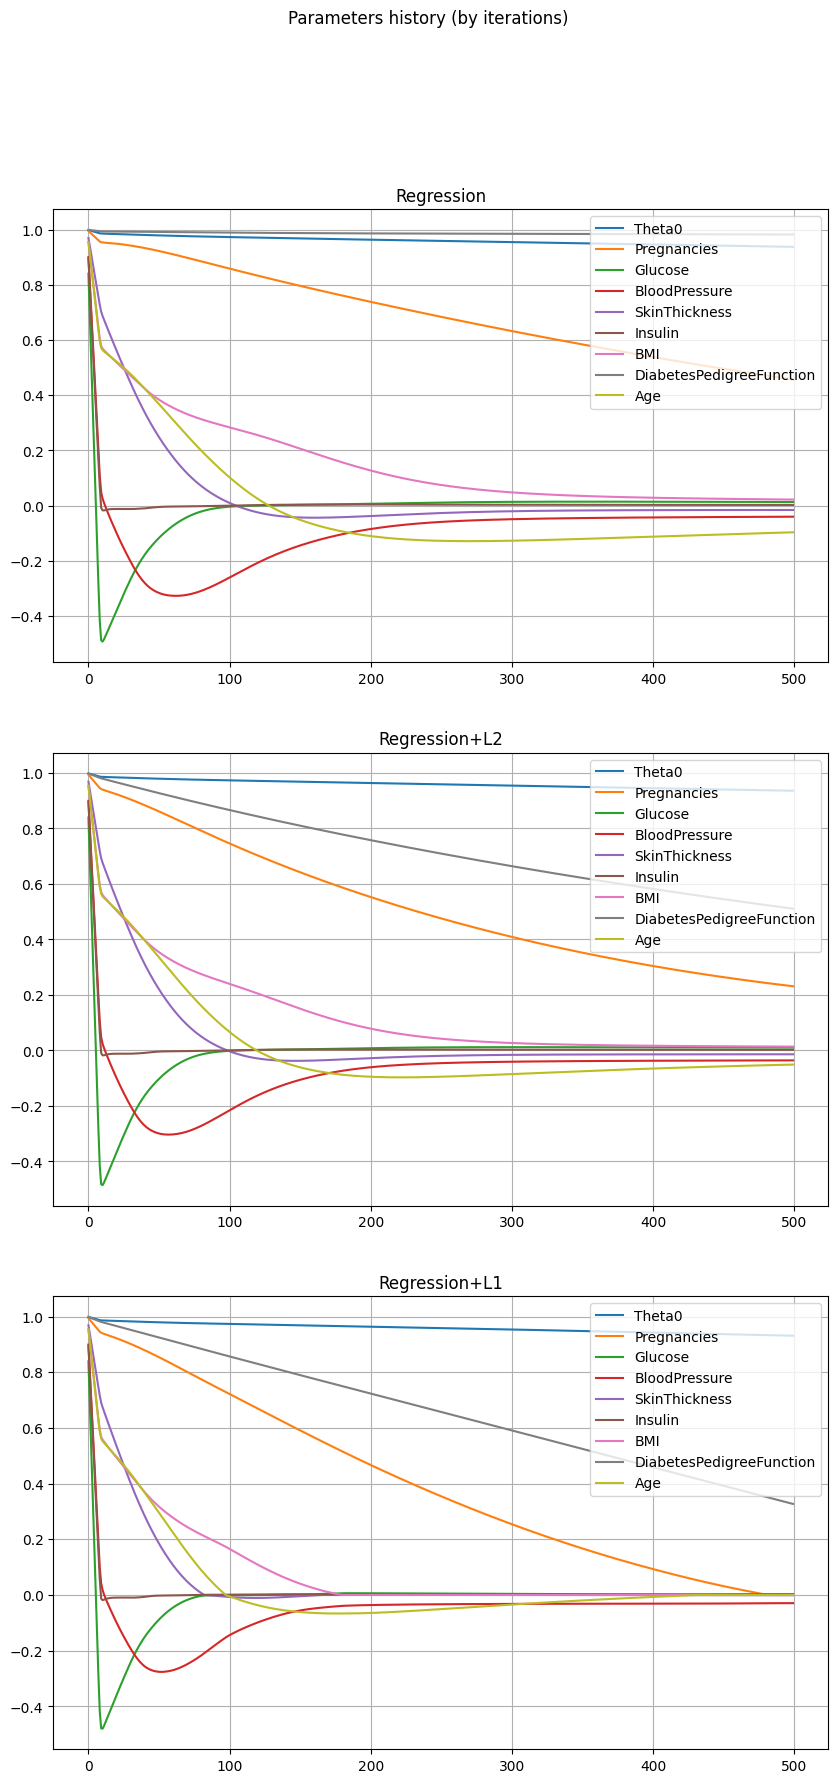

In [17]:
labels = list(diabetes.columns)
labels.pop()
labels = ['Theta0'] + labels
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.suptitle('Parameters history (by iterations)')
fig.set_figwidth (10)
fig.set_figheight(20)
for i in range(len(labels)): 
    ax1.plot(ITLST, history['Theta']['00'][:, i], label=labels[i])
    ax3.plot(ITLST, history['Theta']['L1'][:, i], label=labels[i])
    ax2.plot(ITLST, history['Theta']['L2'][:, i], label=labels[i])

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_title('Regression')
ax2.set_title('Regression+L2')
ax3.set_title('Regression+L1')

ax1.grid()
ax2.grid()
ax3.grid()

plt.show()

**TODO: Analyze the results**

1. Why when we apply regularization, parameters tend to converge more into 0?
1. Why there are parameters which coverge faster than others?
1. Can we find the most important parameters using parameters history? If so, give the two most important ones. Otherwise, explain why.
1. Can we use regularization as feature selection? If so, precise how it can be seen as such. Otherwise, precise why. Discuss L1 and L2 separately.

**Answer**

1. Regularization introduces a penalty term to the model's primary objective function. The optimization process minimizes the total loss, which now includes this penalty. When we apply regularization, we tend to penalize larger parameter values, shrinking them close to 0 in case of L2 but making some parameters exactly 0 in case of L1, thus preventing the model from being too complex and overfit on the training data.
   
1. The parameters corresponding to irrelevant or redundant features converge faster towards zero. Features that have little impact on the outcome are subjected to the full effect of the regularization penalty, causing their corresponding weights ($\theta_j$) to be suppressed to zero (L1) or reduced to a value close to zero (L2). Conversely, parameters for highly important features retain larger values longer as the model requires them to minimize the primary cost function $J_{\text{cost}}(\theta)$.
   
1. Yes, we can identify the most important parameters using the parameter history. They are those that: 1) maintain the largest absolute value (furthest from zero) after convergence, and 2) are most resistant to the shrinking effect of the penalty.  Analyzing the L1 and L2 graphs after 500 iterations, the most important features (excluding the bias $\theta_0$ ) are Pregnancies and DiabetesPedigreeFunction.

1. Yes, regularization can be used for feature selection, with L1-regularization being the most suitable technique for this task.

    - L1 Regularization (Lasso): Yes, L1 can be used for feature selection. Because the L1 penalty term involves the absolute value of the parameters, it is known to drive the coefficients of irrelevant features to exactly zero after convergence. In this case, the features associated with zeroed parameters are eliminated, effectively performing embedded feature selection.

   - L2 Regularization (Ridge): does not set irrelevant feature weights exactly to 0, it shrinks them toward 0, reducing the impact of less significant features. The important features are those with parameter values far from 0, while features with values close to 0 can be considered for removal, it is not used exacly for feature selection, but we can set a sort of threshold, to exlude all features with weights below a certain value. L2 is used for weight shrinkage and stability, not for eliminating features.

### II.2. Features selection

We will use the same dataset to test different feature selection techniques.

#### II.2.1. Filtering using ANOVA

For each feature, ANOVA F-value is calculated.


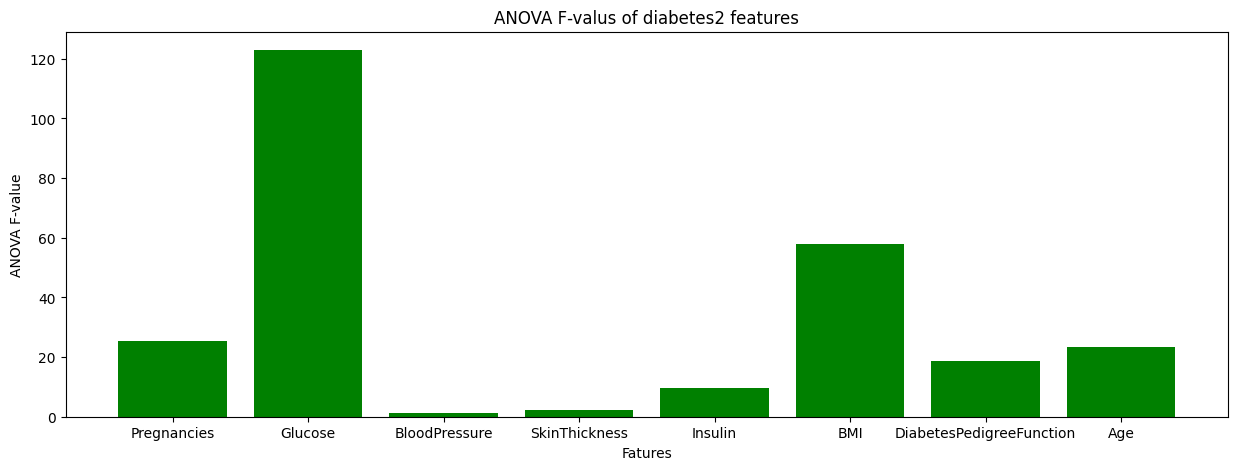

In [18]:
f, a = f_classif(X_train, Y_train)

labels_diabetes = list(diabetes.columns[:-1])
x_pos = range(len(f))
plt.figure(figsize=(15,5))
plt.bar(labels_diabetes, f, color='green')
plt.xlabel('Fatures')
plt.ylabel('ANOVA F-value')
plt.title('ANOVA F-valus of diabetes2 features')

plt.xticks(x_pos, labels_diabetes)

plt.show()


**TODO: Analyze the results**

1. Give the two most important features according to ANOVA.
1. Why they are considered important? In this case, explain the reasoning behind ANOVA F-value.
1. Why ANOVA was used instead of Pearson?

**Answer**

1. The two most important features, corresponding to the highest bars on the ANOVA F-value plot, are Glucose (F-value $\approx 122$) and BMI (F-value $\approx 58$). A higher F-value => a stronger correlation between the feature and the output => these features are powerful discriminators for the diabetes prediction.

1. In ANOVA, the F-value is calculated as follows: $F = \frac{MSB}{MSW}$ the ratio of between-class variance (MSB) to within-class variance (MSW). A higher F-value indicates that the mean variance between groups (in our case diabetic vs non-diabetic) is larger then the mean variance within groups, so the feature clearly separates the classes. For Glucose and BMI, the high F-values show that their distributions are very different between diabetic and non-diabetic groups, making them highly discriminative and important for predicting diabetes.

1. ANOVA is used when the input is numerical and the output is categorical and it is the standard statistical test (F-value) for evaluating the correlation between them, whereas Pearson's correlation is primarily suited for assessing the linear relationship between two numerical variables (numerical input and output). Since we have a classification task at hand (diabetic vs non-diabetic) and the output variable is categorical, ANOVA was used instead of Pearson.

#### II.2.2. Filtering and fitting/generalization

Here, we will use to select feeatures with 50% variance.
We want to compare two models: one trained on all features and another only on the most important ones according to ANOVA F-value.
F1-score is used to judge both fitting and generalization.


In [19]:
selector    = SelectPercentile(score_func=f_classif, percentile=50)
X_train_new = selector.fit_transform(X_train, Y_train)
X_test_new  = selector.transform(X_test)

lreg_anova = LogisticRegression(penalty=None, solver='saga', max_iter=1, warm_start=True, random_state=0)
init_params(lreg_anova, N=X_train_new.shape[1])

history['F1_test' ]['lreg_anova'] = []
history['F1_train']['lreg_anova'] = []
history['Theta'   ]['lreg_anova'] = []

for it in ITLST:
    lreg_anova.fit(X_train_new, Y_train)
    coef = [lreg_anova.intercept_[0]]
    coef.extend(lreg_anova.coef_.flatten().tolist())
    history['Theta'   ]['lreg_anova'].append(coef)
    history['F1_test' ]['lreg_anova'].append(f1_score(Y_test, lreg_anova.predict(X_test_new)))
    history['F1_train']['lreg_anova'].append(f1_score(Y_train, lreg_anova.predict(X_train_new)))


history['Theta']['lreg_anova'] = np.array(history['Theta']['lreg_anova'])


# This is just to check the last time this was executed
# because the next cells depend on the results of this one
now = datetime.datetime.now()
print(now.strftime("%Y-%m-%d %H:%M:%S"))

2025-12-16 15:32:12


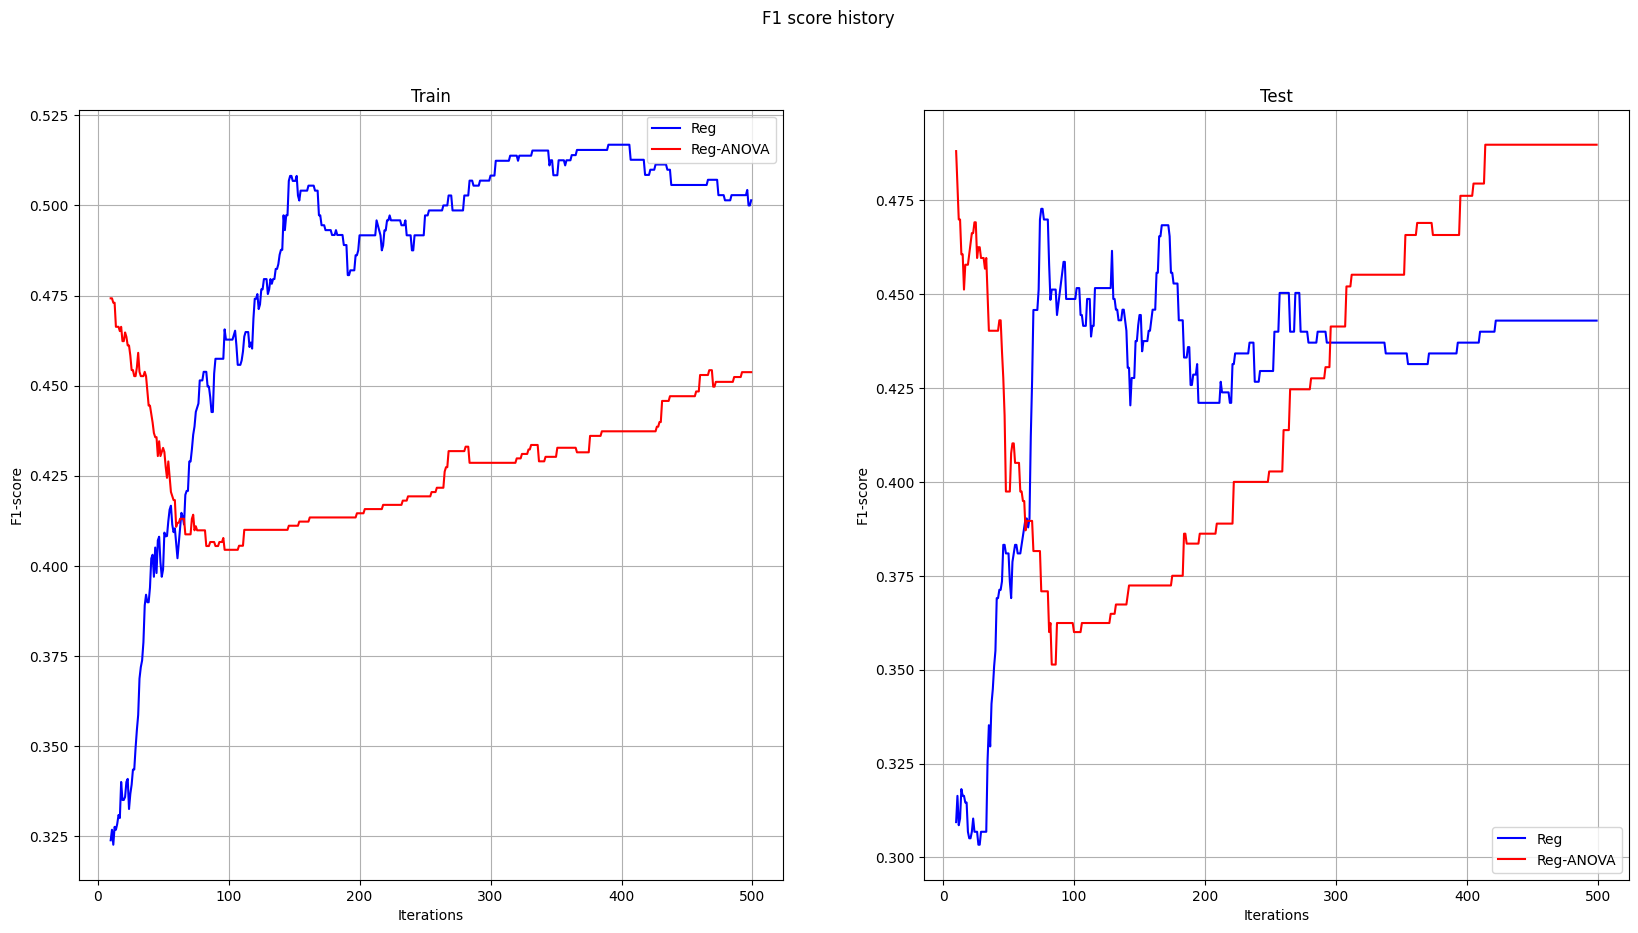

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('F1 score history')
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(ITLST[10:], history['F1_train' ]['00'        ][10:], color='blue', label='Reg'      )
ax1.plot(ITLST[10:], history['F1_train' ]['lreg_anova'][10:], color='red' , label='Reg-ANOVA')
ax2.plot(ITLST[10:], history['F1_test'  ]['00'        ][10:], color='blue', label='Reg'      )
ax2.plot(ITLST[10:], history['F1_test'  ]['lreg_anova'][10:], color='red' , label='Reg-ANOVA')

ax1.set_xlabel('Iterations')
ax1.set_ylabel('F1-score')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('F1-score')

ax1.legend()
ax2.legend()
ax1.set_title('Train')
ax2.set_title('Test')
ax1.grid()
ax2.grid()

plt.show()

**TODO: Analyze the results**

1. Based on train graph, logistic regression without filtering fits quickly and perfectly. Why filtering features decreases fitting capacity either speeed or prformance?
1. Based on test graph, logistic regression without filtering generalizes quickly with less performance. On the other hand, filtering features generalizes slowly with an increasing performance. Why?
1. **Can** filtering prevent overfitting with more iterations? If so, how? If not, why?
1. **Can** filtering prevent underfitting with less iterations? If so, how? If not, why?

**Answer**

1. The Reg model (all features) fits the training data faster and reaches a higher peak F1-score ($\approx 0.515$) than the Reg-ANOVA model ($\approx 0.455$). This occurs because filtering leads to information loss because we removed some features that could potentially have interactions with other features or provide complementary information that isn't apparent when viewed in isolation, which weakens the model's ability to learn, thus resulting in a lower F1 score on the train set. The Reg model utilizes all available information to achieve a better fit to the observed data points.

1. The **Reg model** would fit perfectly to its training data and quickly, capturing initial data patterns but also simultaneously having all initial features increases the model's complexity, leading to overfitting. **Reg-ANOVA** achieves a higher final generalization score because filtering features **reduces model complexity**. This constraint makes the model slower to converge but since all the relevant features are conserved the model would be less complex, allowing it to generalize better on unseen data which avoid the overfitting.

1. Yes, filtering can prevent overfitting which happens when the model is too complex and has many parameters to learn. By using a Filter method like ANOVA to select only the features strongly correlated with the output, the model's complexity is reduced and the influence of noise is minimized. This reduces the number of parameters to learn and can help prevent overfitting. So with enough iterations, the filtered model only captures the general patterns, and not perfectly match the training set.

1. No, filtering can not typically prevent underfitting. It often risks causing it when too many features are removed. While the ANOVA filter selects good features, the model still requires a sufficient number of iterations to fully learn the complex relationships among those selected features. With fewer iterations, the model makes fewer weight updates, preventing it from reaching the optimal solution. 

#### II.2.3. Feature selection comparison

We want to compare different feature selection methods: 
- **ANOVA**: Filter based feature selection. We selected 4 features.
- **L1**: Embdded feature selection.
- **FFS (Forward Features Selection)**: Wrapper feature selection. It starts by testing one feature, then adding others till reaching the desired features' number. We selected 4 features.
- **BFE (Backward Features Elimination)**: Wrapper feature selection. It starts by testing all features, then deleting one by one till reaching the desired features' number. We selected 4 features.

The generated models using these 4 methods are evaluated using the following criteria:
- **F1 train**: to answer the question '*how much a model can converge to its global solution?*'
- **F1 test**: to answer the question '*how much a model can generalize on unseen data?*'
- **Iterations number**: to answer the question '*how much iterations are enough to converge?*'
- **Pre-train time**: to answer the question '*how much time data takes to be prepared for processing?*'
- **Train time**: to answer the question '*how much time a model takes to be trained?*'

*P.S. Execution takes time; be patient till you die of boredom*


In [21]:
CMAX_ITER = 5000
clreg_000  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)
clreg_l1l  = LogisticRegression(penalty='l1', solver='saga', max_iter=CMAX_ITER)
clreg_anv  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)
clreg_ffs  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)
clreg_bfe  = LogisticRegression(penalty=None, solver='saga', max_iter=CMAX_ITER)

time_pp = {}
time_tr = {}

# Normal Logistic Rgression
# ==============================
start_time = timeit.default_timer()
clreg_000.fit(X_train, Y_train)
time_tr['reg'] = timeit.default_timer() - start_time
# ===============================


# L1 Logistic Rgression
# ===============================
start_time = timeit.default_timer()
clreg_l1l.fit(X_train, Y_train)
time_tr['l1'] = timeit.default_timer() - start_time
# ===============================

# Normal Logistic Rgression
# using ANOVA selected features
# ===============================
# Features selection before training
selector_anova = SelectPercentile(score_func=f_classif, percentile=50)
start_time = timeit.default_timer()
X_train_anova = selector_anova.fit_transform(X_train, Y_train)
time_pp['anova'] = timeit.default_timer() - start_time
X_test_anova = selector_anova.transform(X_test)
# Training on selected features
start_time = timeit.default_timer()
clreg_anv.fit(X_train_anova, Y_train)
time_tr['anova'] = timeit.default_timer() - start_time
# ===============================

# Logistic Rgression
# using FFS selected features
# ===============================
# Features selection before training
start_time = timeit.default_timer()
selecteur_ffs = SequentialFeatureSelector(clreg_ffs, n_features_to_select=4, direction='forward')
X_train_ffs = selecteur_ffs.fit_transform(X_train, Y_train)
time_pp['ffs'] = timeit.default_timer() - start_time
X_test_ffs = selecteur_ffs.transform(X_test)
# Training on selected features
start_time = timeit.default_timer()
clreg_ffs.fit(X_train_ffs, Y_train)
time_tr['ffs'] = timeit.default_timer() - start_time
# ===============================

# Logistic Rgression
# using BFE selected features
# ===============================
# Features selection before training
start_time = timeit.default_timer()
selecteur_bfe = SequentialFeatureSelector(clreg_bfe, n_features_to_select=4, direction='backward')
X_train_bfe = selecteur_bfe.fit_transform(X_train, Y_train)
time_pp['bfe'] = timeit.default_timer() - start_time
X_test_bfe = selecteur_bfe.transform(X_test)
# Training on selected features
start_time = timeit.default_timer()
clreg_bfe.fit(X_train_bfe, Y_train)
time_tr['bfe'] = timeit.default_timer() - start_time
# ===============================

pd.DataFrame({
    'Criteria' : ['F1 Train', 
                  'F1 Test', 
                  'Iterations', 
                  'Pre-train time', 
                  'Train time'],
    'Reg'      : [f1_score(Y_train, clreg_000.predict(X_train)), 
                  f1_score(Y_test, clreg_000.predict(X_test)),
                  clreg_000.n_iter_, 
                  0, 
                  time_tr['reg']],
    'Reg+L1'   : [f1_score(Y_train, clreg_l1l.predict(X_train)), 
                  f1_score(Y_test, clreg_l1l.predict(X_test)), 
                  clreg_l1l.n_iter_, 
                  0, 
                  time_tr['l1']],
    'ANOVA+Reg': [f1_score(Y_train, clreg_anv.predict(X_train_anova)), 
                  f1_score(Y_test, clreg_anv.predict(X_test_anova)), 
                  clreg_anv.n_iter_, 
                  time_pp['anova'], 
                  time_tr['anova']],
    'FFS'      : [f1_score(Y_train, clreg_ffs.predict(X_train_ffs)), 
                  f1_score(Y_test, clreg_ffs.predict(X_test_ffs)), 
                  clreg_ffs.n_iter_, 
                  time_pp['ffs'], 
                  time_tr['ffs']],
    'BFE'      : [f1_score(Y_train, clreg_bfe.predict(X_train_bfe)), 
                  f1_score(Y_test, clreg_bfe.predict(X_test_bfe)), 
                  clreg_bfe.n_iter_, 
                  time_pp['bfe'], 
                  time_tr['bfe']],
})

,Criteria,Reg,Reg+L1,ANOVA+Reg,FFS,BFE
0,F1 Train,0.465574,0.465574,0.382671,0.567568,0.585526
1,F1 Test,0.393443,0.380165,0.37931,0.564516,0.539683
2,Iterations,[1408],[1404],[174],[5000],[5000]
3,Pre-train time,0,0,0.002663,46.129327,84.196141
4,Train time,0.438408,0.497827,0.027646,0.958498,1.027169


**TODO: Analyze the results**

1. Why L1-based model takes more time to train than the one using normal one although it takes less iterations?
1. Why L1-based model takes less iterations to converge than normal one?
1. We've seen in the past experiment that ANOVA can generalize better. But, in here it is not as good as normal regression. Why?
1. Why wrapper-based models take more time to train than the normal one although they use less features?
1. Why wrapper-based models give better performance (fitting and generalization) than filter based (ANOVA) one?
1. What can we conclude when we see that wrapper-based models reach the maximum iterations?
1. When FFS pretrain time is better than that of BFE and the inverse?

**Answer**

1. Although the L1-regularized model converges in a similar number of iterations (1404 vs 1406), its training time is higher ($0.48s$ vs $0.39s$). This is because the L1 penalty term ($|\theta_j|$) is non-differentiable at zero, and the parameters are updated by saga solver at each iteration using the proximal algorithm. While the L1-based model requires fewer iterations to converge, each iteration is more computationally expensive. In contrast, the normal regression model only uses GD, involving fewer computations per iteration, resulting in a shorter training time.

1. L1 regularization has an embadded mechanism that constraints the model parameters to a smaller search space. Features with no significant impact on the output variable will have their coefficients reduced to exactly 0. So, L1 regularization converges faster (in terms of number of iterations) than the normal model because it has fewer parameters to update, focusing only on the parameters of the relevant features.

1.  In this full-iteration run, the ANOVA model severely **underfits** the data (F1 Train $\approx 0.38$) compared to the Reg model (F1 Train $\approx 0.46$). The low performance across both sets suggests that the **Filter method's** selection of only the top 50% of features was too aggressive for this full training configuration and ANOVA removes information that the logistic regression needs to properly fit the data. The limited feature set restricted the model's capacity to adequately capture the training data patterns, leading to suboptimal generalization performance compared to the model using all eight features.

1. The primary time cost for Wrapper models is not in the final training but in the **Pre-train time** (feature selection). Wrapper methods must iteratively train and evaluate the Logistic Regression model multiple times (with cross-validation) on many different feature subsets to find the optimal set of four. This exhaustive, coupled search makes the overall feature selection process computationally expensive, dominating the total runtime (FFS at $0.98s$), even though the final model is trained on fewer features.

1. Wrapper methods give better fitting and generalization than ANOVA because they evaluate features based on their combined contribution to the model’s performance. By selecting the subset of four features that maximizes Logistic Regression performance, wrapper methods implicitly account for feature interactions. In contrast, ANOVA is a filter method that evaluates each feature independently of the model and ignores interactions, which leads to the removal of informative feature combinations and results in underfitting.
   
1. When wrapper-based models reach the maximum iteration limit (5000), it indicates that the optimization on the selected feature subset did not converge within the allowed iterations.
   
1.  FFS is faster when there are few relevant features ($k$) from the total number of features ($N$), so FFS would directly pick them up first, while BFE would remove a lot of features before arriving to the final subset (higher pretraining time for BFE). On the other hand, BFE would be faster if the majority of features are relevant, so BFE would remove few features before arriving to the best subset, while FFS would have to add a lot of features before building the best subset (higher pre-training time for FFS this time).

In [22]:
print('This lab is finished, and all ML\'s suffering with it')

This lab is finished, and all ML's suffering with it
